## EEP 502: Analytical Methods for Electrical Engineering
    
# Final project
## Due December 14, 2024 at 11:59 PM
Copyright &copy; 2024, University of Washington

<hr>

**Instructions**: Choose **<u>one</u>** of the following problems. Solve the problem and then write up your solution in a stand-alone Jupyter Notebook. Your notebook should have the following elements:

- Problem statement
- Mathematical description of the solution
- Executable, commented, clear code

You will be graded on how well your notebook reads like a nicely formated, well written report. You must:

- Write mathematical descriptions using complete sentences, paragraphs, and LaTeX formulas.
- Comment your code as necessary, with a description of what each function does, and all major steps.
- Label plots axes, use legends, and use plot titles.
- Before submitting a notebook, choose Kernel -> Restart and Run All to make sure your notebook runs when the cells are evaluated in order.

<span style="color: red'">
Although you may discuss the project with others, you must turn in your own, original work.
</span>


In [14]:
import networkx as nx
import math
import scipy
import scipy.integrate as spi
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib inline

# Differential Equations for Neural Networks

The computational neural networks we have been studying are quite far from what is happening in biology. A slightly more realistic model is to admit that each neuron $i$ in a network has a time varying firing rate $x_i$, for $i$ equal $1$ to $n$. We let $W \in \mathbb{R}^{n \times n}$ be weight matrix, and $b \in \mathbb{R}^n$. The dynamics of such a neural network are

$$
\dot x_i = g \left (
\sum_{j=1}^n w_{i,j} x_j + b_i
\right )
$$

where is the nonlinearity

$$
g(x) = \frac{1}{1+e^{-x}} - \frac{1}{2} .
$$

*a)* Show through simulation that the matrix

$$
W = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

with $b = 0$ results in oscillations. This is called a ring oscillator. Draw a graph representation of it. Now show through simulation that a ring of $n$ neurons so arranged oscillates when $n$ is odd, but not when it is even.

*b)* Define $W$ and $b$ so that the resulting network is bistable. That is, when one neuron is on in steady state, another is off, and *vice versa*. Simulate the system with different initial conditions. Draw a graph representation of your network.

*c)* Build a network that contains two subnetworks that oscillate, that are connected in such a way that if one subnetwork oscillates, it prevents the other from oscillating, and *vice versa*. Simulate the system with different initial conditions to show the desired behavior. Draw a graph representation of your network.

*d)* Define $W \in \mathbb{R}^{n \times n}$ and $b \in \mathbb{R}^n$ with $n = 50$ to be a random neural network.

Given a number $p \in [0,1]$, define a random matrix $A$ as follows. For each $i,j$, choose $r \in [0,1]$ randomly. Then put

$$
A_{i,j} = \left \{
\begin{array}{ll}
1 & \mathrm{if} & r \leq \frac{p}{2} \\
-1 & \mathrm{if} & \frac{p}{2} < r \leq p \\
0 & \mathrm{otherwise}.
\end{array}
\right .
$$

Then put

$$
W = A - I
$$

where $I$ is the identity matrix. Through simulations with $n=20$, explain the various behaviors you can get with various values of $p$.

In [15]:
 def nonlinearity_func(x):
    """Model of nonlinearity function that represents the time varying component of a neuron's firing rate
    
    
    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | output    | g_x                           | Real number that models firing rate of neuron $i$ in a neural network                                                             |


    No Exception Handling Provided
    """

    return ((1/(1+np.exp(-x))) - (1/2))

In [16]:
def neuron_firing_rate_func(    t,
                                weight_vector_i,
                                neuron_firing_rate_vector_i,
                                neuron_bias_i
                                ):
    """Function sums the weighted inputs from all the neurons in the neural network into neuron $i$ and adds an activation threshold bias to change the firing threshold of neuron $i$.
       
    
    Function feeds the weighted neuron input + activation threshold bias into the nonlinearity function to model the firing rate of neuron $i$ as a function of time. 


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | input     | weight_vector_i               | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$            |
    | input     | neuron_firing_rate_vector_i   | Vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network.                   |
    | input     | neuron_bias_i                 | Real number that adjusts neuron $i$'s activation threshold                                                                        |
    | output    | nonlinearity_func             | Real number that models firing rate of neuron $i$ in a neural network. Refers to g(x) nonlinearity equation                       |


    No Exception Handling Provided
    """
    # Calculate the weighted sum of neuron firing rates into neuron $i$
    x = np.dot(weight_vector_i,neuron_firing_rate_vector_i) + neuron_bias_i

    # Nonlinearity function g(x) models the activation of neuron x_i
    return nonlinearity_func(x)

In [17]:
def neuron_ode( weight_matrix_i,
                init_neuron_firing_rate_vector_i,
                time_steps_i,
                neuron_bias_i,    
                t_eval_i
                ):
    """Function uses an ODE solver to calculate the activation rate for each neuron in the neural network as a function of time


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                                                                                               |
    | -         | -                                 | -                                                                                                                                                                                                                         |
    | input     | weight_matrix_i                   | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$                                                                                                    |
    | input     | init_neuron_firing_rate_vector_i  | Initial vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network. The ODE solver will calculate firing rates as a function of time but requires an initial state    |
    | input     | time_steps_i                      | List that contains interval of integration (t0, tf). The ODE solver starts with t=t0 and integrates until it reaches t=tf. Both t0 and tf must be floats or values interpretable by the float conversion function.        |
    | input     | neuron_bias_i                     | Real number that adjusts neuron $i$'s activation threshold                                                                                                                                                                |
    | input     | t_eval_i                          | Times steps which to store the evaluated solution, must be sorted and lie within time_steps_i. If None (default), use points selected by the ODE solver.                                                                  |
    | output    | neuron_activation_rates.t         | Array of real numbers returned by the ODE solver that contains the evaluation times t, constrained by t_eval_i                                                                                                            |
    | output    | neuron_activation_rates.y         | Array of real numbers returned by the ODE solver that contains the evaluated values y for each time interval t. Total y is constrained by t_eval_i                                                                        |

    
    No Exception Handling Provided
    """

    # Use scipy solve_ivp to solve ODE equations. 
    # Currently unsure of which ODE method to use, so following scipy documentation I will use the default method, RK45, since it returns reasonable values
    neuron_activation_rates =   spi.solve_ivp(  lambda t,x : neuron_firing_rate_func(t,weight_matrix_i,x,neuron_bias_i),
                                                time_steps_i,
                                                init_neuron_firing_rate_vector_i,
                                                "RK45",
                                                t_eval_i
                                                )
    return neuron_activation_rates.t,neuron_activation_rates.y

In [18]:
# Based on the weighted matrix conditions, activation threshold bias, and odd number of neurons specified by a), each neuron should exhibit oscillatory behavior

# Setup initial conditions to model 3 neuron neural network ring oscillator
# Initializing weighted matrix
W_ring_osc = np.array([
                [1,2,0],
                [0,1,2],
                [2,0,1]
])
W_ring_osc = (W_ring_osc*(-1))
# Initializing activation bias
b = np.zeros(3)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
init_neuron_firing_rate_vector = np.array([random.uniform(0,30) for i in range(3)]).reshape(3,)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)


W_ring_osc, init_neuron_firing_rate_vector,b

(array([[-1, -2,  0],
        [ 0, -1, -2],
        [-2,  0, -1]]),
 array([ 1.72344461,  4.7748752 , 24.11684309]),
 array([0., 0., 0.]))

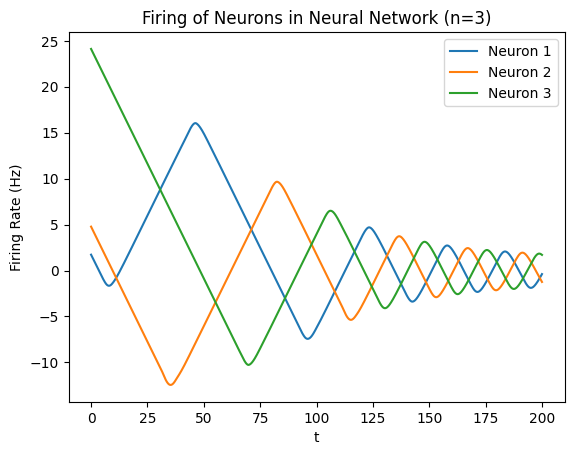

In [19]:
# Plot the simulated behavior of a three neuron neural network
t,y = neuron_ode(W_ring_osc,init_neuron_firing_rate_vector,time_steps,b,t_eval)

# Plot the firing of each neuron in neural network
for i in range(3):
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=3)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

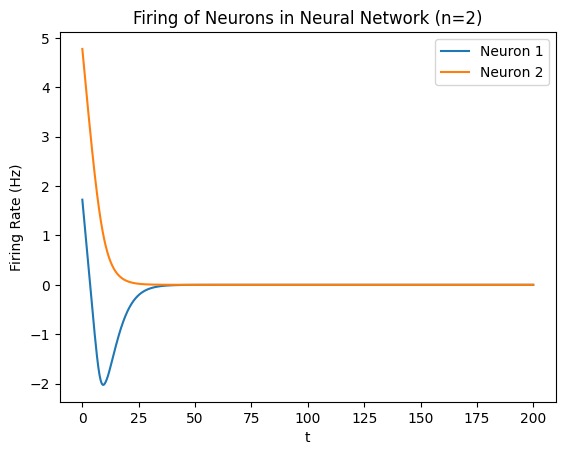

In [20]:
# By reducing the number of neurons from an odd 3 neurons to an even 2 neurons, the two neurons should not oscillate and instead converge to zero as their outputs are dampened

# Plot the simulated behavior of a two neuron neural network
t,y = neuron_ode(W_ring_osc[:2,:2],init_neuron_firing_rate_vector[:2],time_steps,b[:2],t_eval)

# Plot the firing of each neuron in neural network
for i in range(2):  
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=2)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

In [21]:
def gen_nn_nodes(num_biases_i,G_i):
    """Function generates the nodes of the neural network based on the depth of activation threshold bias vector $b$.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | output    | g_x                           | Real number that models firing rate of neuron $i$ in a neural network                                                             |


    No Exception Handling Provided
    """

    # start node count from 1 rather than zero, because it matches the legend in the neuron firing graphs
    for i in range(1,len(num_biases_i)+1):
        G_i.add_node(i)

    return G_i

In [22]:
def gen_nn_edges(adjacency_matrix_i,G_i):
    """Function generates the edges of the neural network based on the weight matrix $W$ of the network.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | output    | g_x                           | Real number that models firing rate of neuron $i$ in a neural network                                                             |


    No Exception Handling Provided
    """
    
    dimensions = adjacency_matrix_i.shape
    rows,columns = dimensions

    for i in range(1,rows+1):
        for j in range(1,columns+1):
            if (adjacency_matrix_i[i-1,j-1] != 0):
                G_i.add_edge(i,j,weight=adjacency_matrix_i[i-1,j-1])

    return G_i

In [28]:
def draw_nn(G_i,ax_i):
    # Draw neural network
    nx.draw(G_i,
            ax=ax_i,
            pos=nx.circular_layout(G_i),
            with_labels=True,
            node_color='#444444',
            font_color="white")
    nx.draw_networkx_edge_labels(G_i, 
                                pos=nx.circular_layout(G_i), 
                                edge_labels=nx.get_edge_attributes(G_i, "weight"))

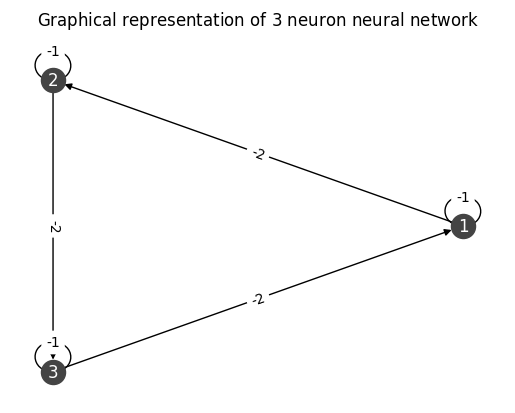

In [29]:
# Graphical representation of 3 neuron neural network based on the weighted connection matrix W

# Create networkX graph variable
G_ring_oscillator = nx.DiGraph()
G_ring_oscillator = gen_nn_nodes(b,G_ring_oscillator)
G_ring_oscillator = gen_nn_edges(W_ring_osc,G_ring_oscillator)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (3))

draw_nn(G_ring_oscillator,ax)

[0.30038399 0.74664936 0.96809627]
<class 'numpy.ndarray'> (3,)


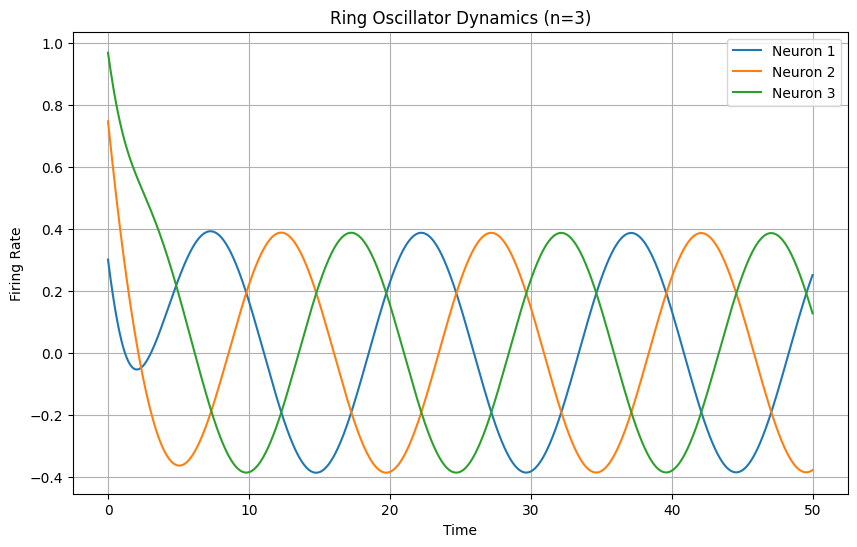

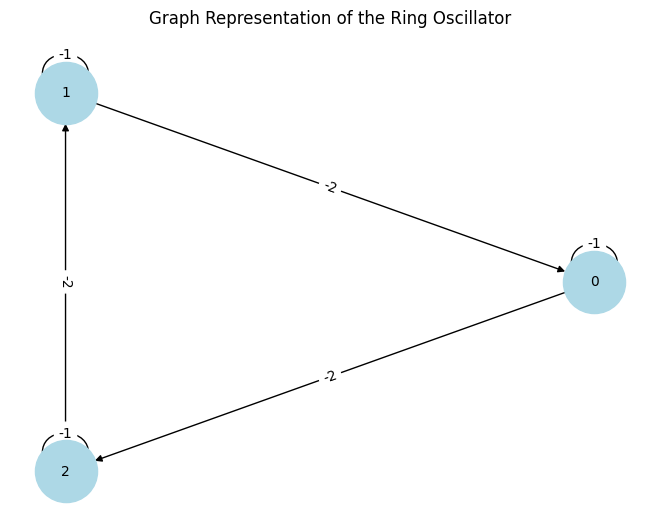

In [24]:
# Define the nonlinearity g(x)
def g(x):
    return 1 / (1 + np.exp(-x)) - 0.5

# Define the dynamics of the system
def ring_oscillator(t, x, W, b):
    return g(W @ x + b)

# Function to simulate the system
def simulate_ring_oscillator(W, b, t_span, x0, t_eval):
    print(type(x0),x0.shape)
    # Solve the differential equation
    sol = spi.solve_ivp(
        fun=lambda t, x: ring_oscillator(t, x, W, b),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method="RK45"
    )
    return sol.t, sol.y

# Define the weight matrix W for n=3
W = -np.array([[1, 2, 0],
               [0, 1, 2],
               [2, 0, 1]])
b = np.zeros(3)  # Bias vector
t_span = (0, 50)  # Time span for simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points to evaluate
x0 = np.random.rand(3)  # Initial state (random)

# Simulate the ring oscillator for n=3
print(x0)
t, x = simulate_ring_oscillator(W, b, t_span, x0, t_eval)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(t, x[i], label=f"Neuron {i+1}")
plt.title("Ring Oscillator Dynamics (n=3)")
plt.xlabel("Time")
plt.ylabel("Firing Rate")
plt.legend()
plt.grid()
plt.show()

# Draw the graph representation of the ring oscillator
def draw_ring_graph(W):
    G = nx.DiGraph()
    n = W.shape[0]
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                G.add_edge(j, i, weight=W[i, j])
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Graph Representation of the Ring Oscillator")
    plt.show()

draw_ring_graph(W)


Simulating for n = 3...


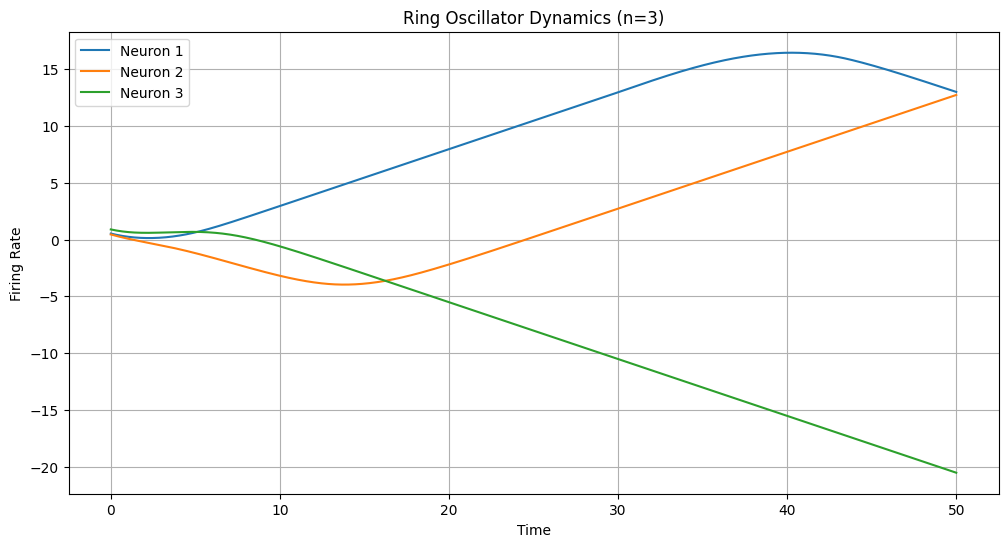

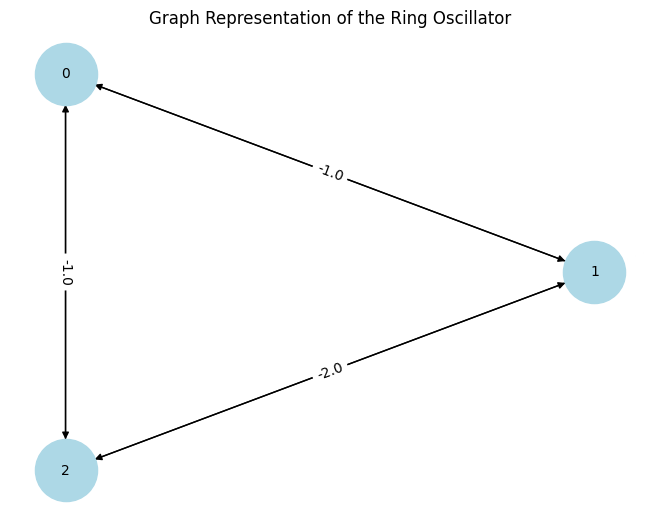

Simulating for n = 4...


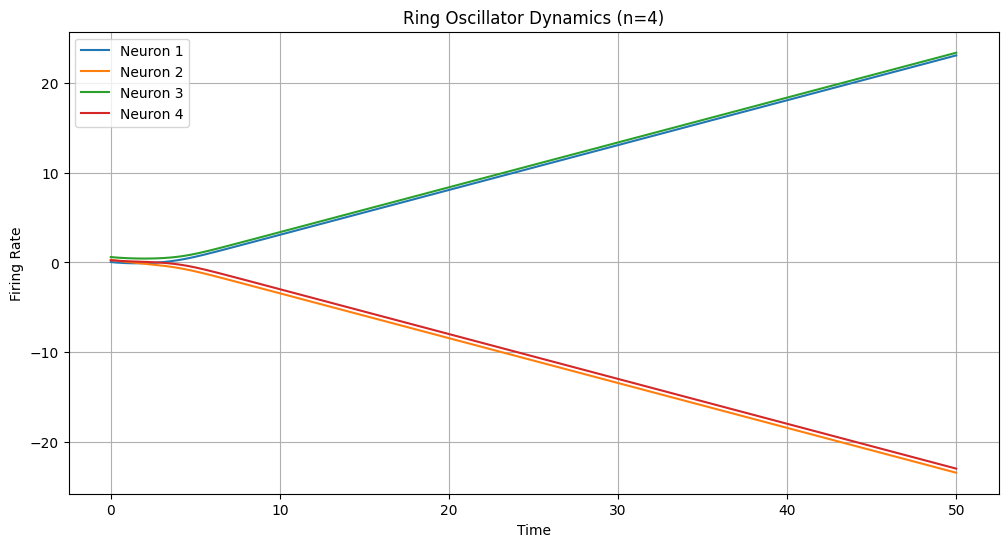

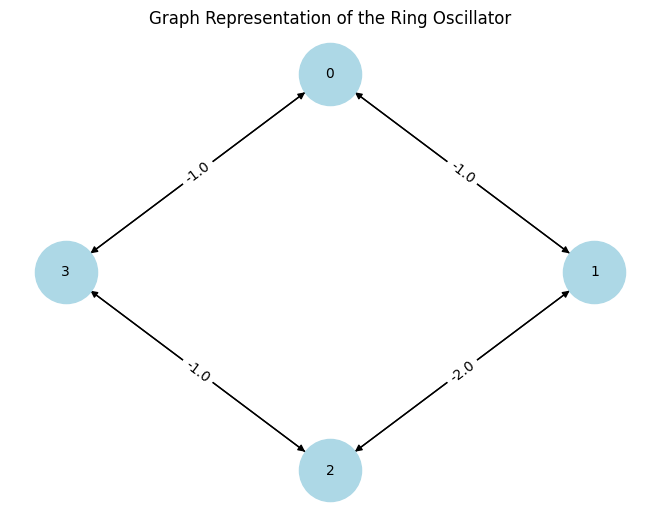

Simulating for n = 5...


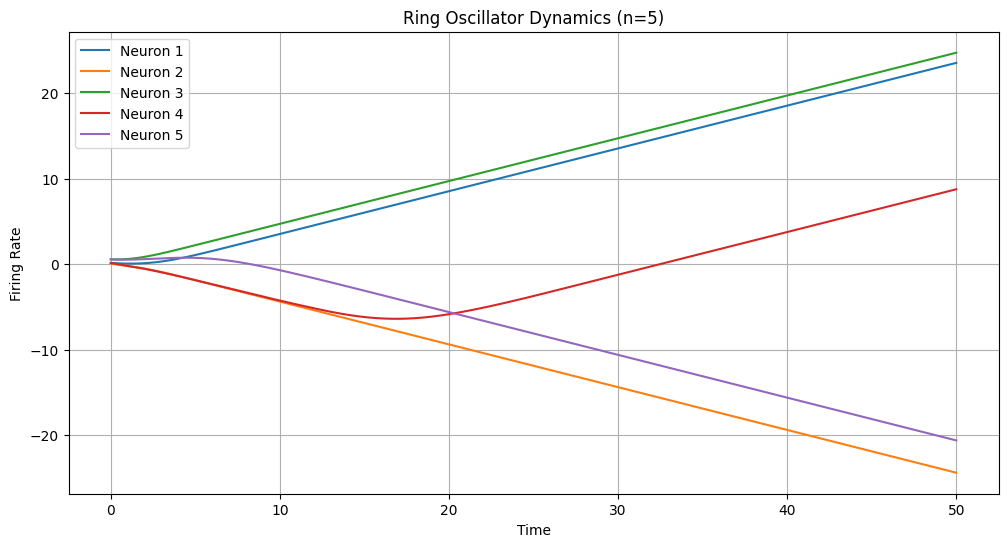

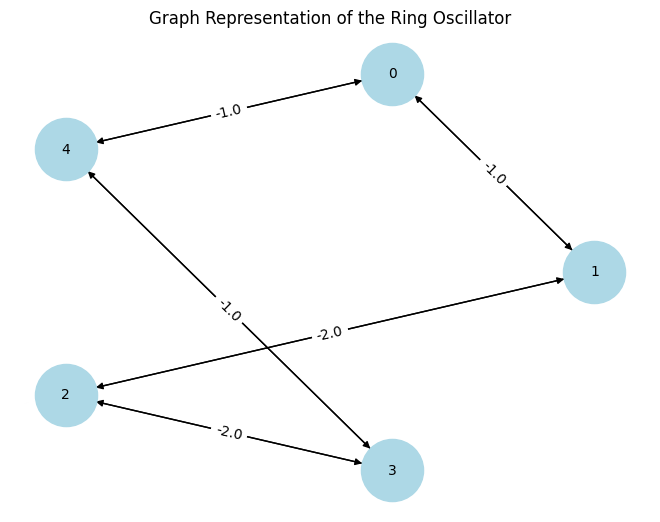

Simulating for n = 6...


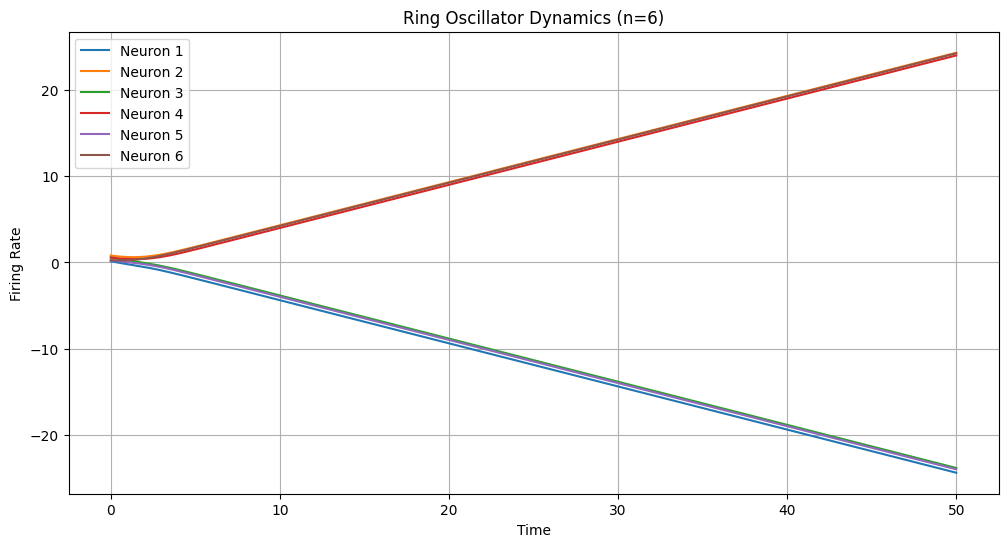

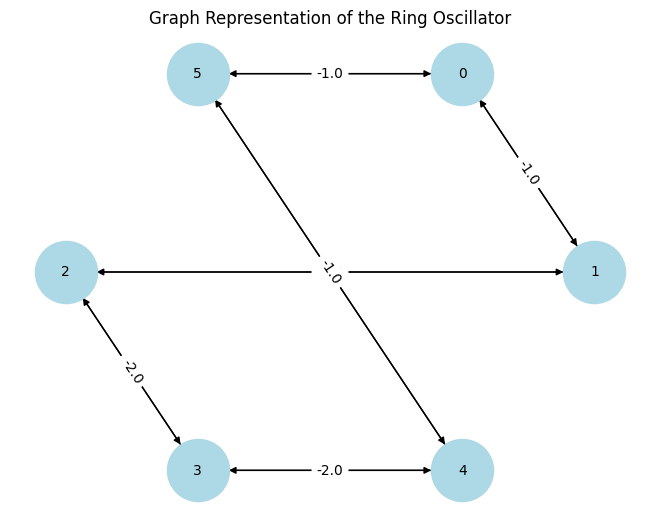

In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx

# Define the nonlinearity g(x)
def g(x):
    return 1 / (1 + np.exp(-x)) - 0.5

# Define the dynamics of the system
def ring_oscillator(t, x, W, b):
    return g(W @ x + b)

# Function to simulate the system
def simulate_ring_oscillator(W, b, t_span, x0, t_eval):
    sol = solve_ivp(
        fun=lambda t, x: ring_oscillator(t, x, W, b),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method="RK45"
    )
    return sol.t, sol.y

# Function to construct a ring weight matrix for given n
def construct_ring_matrix(n):
    W = np.zeros((n, n))
    for i in range(n):
        W[i, (i+1) % n] = 2  # Connect to the next neuron (clockwise)
        W[i, (i-1) % n] = 1  # Connect to the previous neuron (counterclockwise)
    return -W

# Simulate and plot results for arbitrary n
def simulate_and_plot(n, t_span=(0, 50), t_eval=np.linspace(0, 50, 1000)):
    W = construct_ring_matrix(n)
    b = np.zeros(n)  # Bias vector
    x0 = np.random.rand(n)  # Initial state (random)
    
    # Simulate the dynamics
    t, x = simulate_ring_oscillator(W, b, t_span, x0, t_eval)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(t, x[i], label=f"Neuron {i+1}")
    plt.title(f"Ring Oscillator Dynamics (n={n})")
    plt.xlabel("Time")
    plt.ylabel("Firing Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Draw the graph representation
    draw_ring_graph(W)

# Draw the graph representation of the ring oscillator
def draw_ring_graph(W):
    G = nx.DiGraph()
    n = W.shape[0]
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                G.add_edge(j, i, weight=W[i, j])
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Graph Representation of the Ring Oscillator")
    plt.show()

# Simulate for odd and even values of n
for n in [3, 4, 5, 6]:  # Test with both odd and even n
    print(f"Simulating for n = {n}...")
    simulate_and_plot(n)


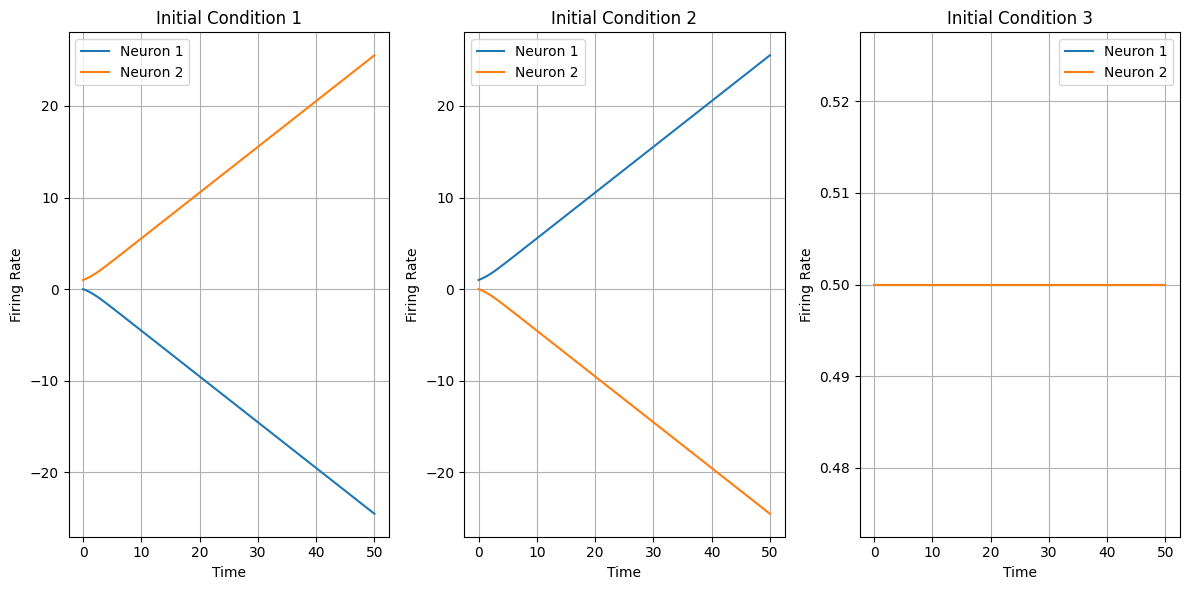

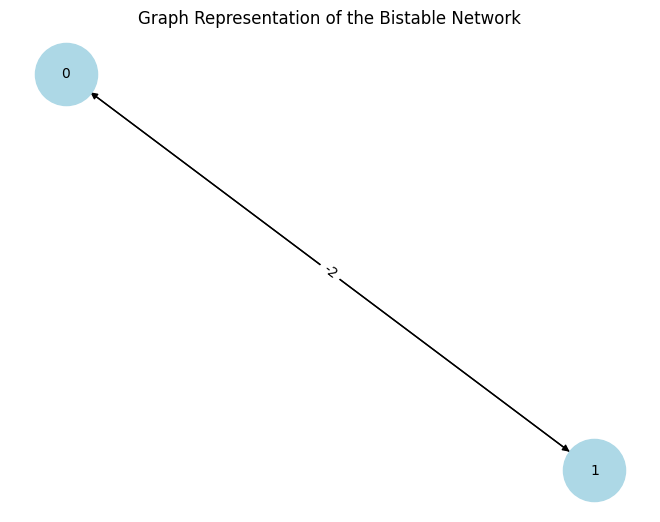

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx

# Define the nonlinearity g(x)
def g(x):
    return 1 / (1 + np.exp(-x)) - 0.5

# Define the dynamics of the system
def bistable_dynamics(t, x, W, b):
    return g(W @ x + b)

# Function to simulate the bistable system
def simulate_bistable(W, b, t_span, x0, t_eval):
    sol = solve_ivp(
        fun=lambda t, x: bistable_dynamics(t, x, W, b),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method="RK45"
    )
    return sol.t, sol.y

# Define W and b for the bistable network
def define_bistable_network():
    # Mutual inhibition: each neuron suppresses the other
    W = np.array([[0, -2],  # Neuron 1 inhibits Neuron 2
                  [-2,  0]])  # Neuron 2 inhibits Neuron 1
    b = np.array([1, 1])  # Slight bias to push activation
    return W, b

# Simulate and plot the bistable network
def simulate_and_plot_bistable(t_span=(0, 50), t_eval=np.linspace(0, 50, 1000)):
    W, b = define_bistable_network()
    initial_conditions = [np.array([0, 1]), np.array([1, 0]), np.array([0.5, 0.5])]

    plt.figure(figsize=(12, 6))
    for i, x0 in enumerate(initial_conditions):
        # Simulate dynamics
        t, x = simulate_bistable(W, b, t_span, x0, t_eval)

        # Plot the dynamics
        plt.subplot(1, len(initial_conditions), i + 1)
        plt.plot(t, x[0], label="Neuron 1")
        plt.plot(t, x[1], label="Neuron 2")
        plt.title(f"Initial Condition {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Firing Rate")
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

    # Draw the graph representation
    draw_bistable_graph(W)

# Draw the graph representation of the bistable network
def draw_bistable_graph(W):
    G = nx.DiGraph()
    n = W.shape[0]
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                G.add_edge(j, i, weight=W[i, j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Graph Representation of the Bistable Network")
    plt.show()

# Simulate and plot the bistable network
simulate_and_plot_bistable()
